In [3]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

%matplotlib inline

In [5]:
df = pd.read_csv('C:\\R\\tagged_plots_movielens.csv')
df = df.dropna()
df['plot'].apply(lambda x: len(x.split(' '))).sum()

171156

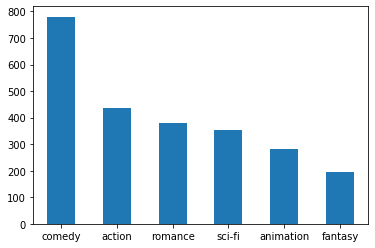

In [6]:
my_tags = df.tag.unique()
df.tag.value_counts().plot(kind="bar", rot=0)

In [7]:
df

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy
3,3,6,Hunters and their prey--Neil and his professio...,action
4,4,7,An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
2443,2443,148618,Three kids who travel back in time to 65 milli...,animation
2444,2444,148624,"Top Cat and the gang face a new police chief, ...",animation
2445,2445,149088,Raggedy Ann and the rest of the toys in Marcel...,animation
2446,2446,149406,"Continuing his ""legendary adventures of awesom...",comedy


In [8]:
def print_plot(index):
    example = df[df.index == index][['plot', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Genre:', example[1])

In [9]:
print_plot(12)

In a future world devastated by disease, a convict is sent back in time to gather information about the man-made virus that wiped out most of the human population on the planet.
Genre: sci-fi


In [10]:
print_plot(15)

Based on the popular video game of the same name "Mortal Kombat" tells the story of an ancient tournament where the best of the best of different Realms fight each other. The goal - ten wins to be able to legally invade the losing Realm. Outworld has so far collected nine wins against Earthrealm, so it's up to Lord Rayden and his fighters to stop Outworld from reaching the final victory...
Genre: action


In [11]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [12]:
len(test_data)

243

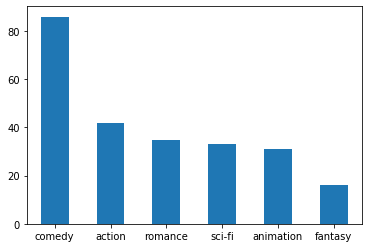

In [13]:
test_data.tag.value_counts().plot(kind="bar", rot=0)

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [16]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

In [17]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [18]:
%%time
# training
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

Wall time: 1.59 s


In [19]:
%%time

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 506 ms


C:\Users\Administrator\anaconda64\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
count_vectorizer.get_feature_names()[80:90]

['adventure',
 'adventures',
 'adventurous',
 'advice',
 'affair',
 'affairs',
 'afraid',
 'africa',
 'african',
 'aftermath']

accuracy 0.448559670781893
confusion matrix
 [[10  2  9  4  3  3]
 [ 3  4  1  5  2  1]
 [ 7  3 48 12 15  1]
 [ 1  0 12 24  3  2]
 [ 3  1 17  1 10  3]
 [ 5  2  5  8  0 13]]
(row=expected, col=predicted)
Wall time: 266 ms


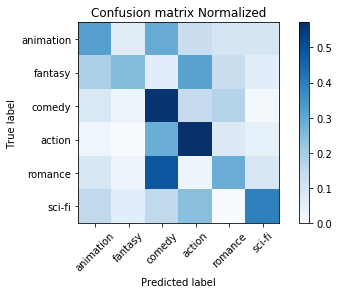

In [21]:
%%time

predict(count_vectorizer, logreg, test_data)

In [22]:
def most_influential_words(vectorizer, genre_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]

In [23]:
# words for the fantasy genre
genre_tag_id = 1
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer, genre_tag_id)

fantasy


['animated',
 'forest',
 'tale',
 'animals',
 'anna',
 'adventurous',
 'snow',
 'halloween',
 'victor',
 'prince']

In [24]:
train_data_features[0]

<1x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [25]:
%%time
n_gram_vectorizer = CountVectorizer(
    analyzer="char",
    ngram_range=([2,5]),
    tokenizer=None,    
    preprocessor=None,                               
    max_features=3000) 

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

train_data_features = n_gram_vectorizer.fit_transform(train_data['plot'])

logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 5.57 s


C:\Users\Administrator\anaconda64\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:

n_gram_vectorizer.get_feature_names()[50:60]

[' are ',
 ' as',
 ' as ',
 ' as a',
 ' as t',
 ' ass',
 ' at',
 ' at ',
 ' at t',
 ' att']

accuracy 0.43209876543209874
confusion matrix
 [[ 7  4  9  4  2  5]
 [ 3  4  3  2  2  2]
 [ 9  4 43 11 16  3]
 [ 2  1 11 20  4  4]
 [ 1  1 11  6 14  2]
 [ 2  4  7  3  0 17]]
(row=expected, col=predicted)


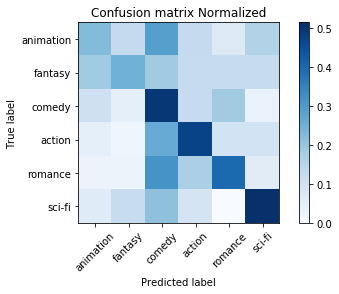

In [27]:
predict(n_gram_vectorizer, logreg, test_data)

In [28]:
%%time
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])

Wall time: 2.33 s


C:\Users\Administrator\anaconda64\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
tf_vect.get_feature_names()[1000:1010]

['caesar',
 'cage',
 'caine',
 'cal',
 'calhoun',
 'california',
 'californians',
 'called',
 'calling',
 'callous']

accuracy 0.4732510288065844
confusion matrix
 [[ 9  2 10  4  4  2]
 [ 5  3  1  5  1  1]
 [ 6  0 53  7 19  1]
 [ 2  1 11 24  3  1]
 [ 1  0 21  1 10  2]
 [ 2  2  5  8  0 16]]
(row=expected, col=predicted)


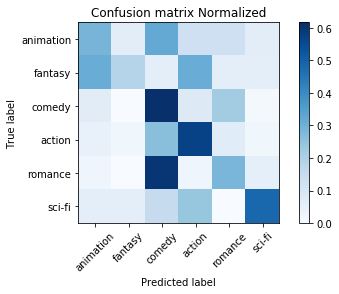

In [30]:
predict(tf_vect, logreg, test_data)

In [31]:

most_influential_words(tf_vect, 1)

['animated',
 'halloween',
 'forest',
 'tale',
 'animals',
 'adventurous',
 'anna',
 'dog',
 'prince',
 'order']